In [3]:
import pandas as pd

def reshape_csv(csv_path: str) -> pd.DataFrame:
    """
    Reshapes the CSV file specified by the given path to have "Wavelength (nm)" as the index and various time points as columns.
    Each cell in the reshaped DataFrame will contain the corresponding "Abs" (absorbance) value.
    Converts all values to float and the "Wavelength (nm)" index to int after rounding.
    
    Args:
    - csv_path (str): The path to the input CSV file.
    
    Returns:
    - pd.DataFrame: The reshaped and converted DataFrame.
    """
    
    # Load the CSV file into a DataFrame
    df = pd.read_csv(csv_path)
    
    # Drop the first row with redundant labels
    df = df.drop(0)
    
    # Using a dictionary to store reshaped data
    reshaped_data = {'Wavelength (nm)': df.iloc[:, 0].values}
    
    # Iterating through pairs of columns and reshaping
    for i in range(0, df.shape[1], 2):
        time_point = df.columns[i]
        if 'Unnamed' not in time_point:
            # Extract the numeric value from the time_point and use it as the key for reshaped_data
            num_minutes = int(''.join(filter(str.isdigit, time_point)))
            reshaped_data[num_minutes] = df.iloc[:, i+1].values

    # Convert the dictionary to a DataFrame
    reshaped_df = pd.DataFrame(reshaped_data)
    reshaped_df = reshaped_df.set_index('Wavelength (nm)')
    
    # Drop rows containing NaN values
    reshaped_df.dropna(axis=0, inplace=True)
    
    # Convert data types
    # Convert all columns to float
    reshaped_df = reshaped_df.astype(float)
    
    # Convert the index (Wavelength) to int after rounding
    rounded_index = pd.Series(reshaped_df.index).astype(float).round().astype(int)
    reshaped_df.index = rounded_index
    
    return reshaped_df

import matplotlib.pyplot as plt
import numpy as np

def plot_spectrum_progression(df: pd.DataFrame):
    """
    Plots the spectrum progression in time. 
    Time progression is plotted as a color gradient between black and red.
    
    Args:
    - df (pd.DataFrame): DataFrame with "Wavelength (nm)" as the index and time points as columns.
    
    Returns:
    - None
    """
    
    # Exclude the BLANK column
    if 'BLANK' in df.columns:
        df = df.drop(columns=['BLANK'])
    
    # Define a color map from black to red based on the number of time points
    cmap = plt.get_cmap('Reds')
    colors = cmap(np.linspace(0.1, 1, len(df.columns)))
    plt.figure()
    # Plot each time series with the corresponding color
    for idx, col in enumerate(df.columns):
        plt.plot(df.index, df[col], label=col, color=colors[idx])
    
    # Add a color bar to indicate time progression
    sm = plt.cm.ScalarMappable(cmap=cmap, 
                               norm=plt.Normalize(vmin=0, vmax=len(df.columns)))
    sm.set_array([])
    cbar = plt.colorbar(sm, ticks=np.linspace(0, len(df.columns), 6))
    cbar.set_label('Time Progression', rotation=270, labelpad=20)
    
    # Other plot adjustments
    plt.title('Spectrum Progression in Time')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Absorbance')

    #plt.legend(loc='upper right', ncol=2, fontsize='small', title='Time Points')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

# Test the function with the refactored DataFrame

def plot_abs_change_at_wavelengths(df: pd.DataFrame, wavelengths: list):
    """
    Plots the absorbance change over time at specified wavelengths.
    
    Args:
    - df (pd.DataFrame): DataFrame with "Wavelength (nm)" as the index and time points as columns.
    - wavelengths (list): List of wavelengths at which absorbance change should be plotted.
    
    Returns:
    - None
    """
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 7))
    
    for wavelength in wavelengths:
        if wavelength in df.index:
            ax.plot(df.columns, df.loc[wavelength]/df.loc[wavelength][0], label=f'{wavelength} nm')
    
    # Plot adjustments
    plt.figure()
    ax.set_title('Absorbance Change Over Time at Specified Wavelengths')
    ax.set_xlabel('Time Points')
    ax.set_ylabel('Absorbance')
    ax.legend(loc='upper right')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



In [10]:
def AAE_progression(df):
    df_log_log = df.copy()
    df_log_log = df_log_log[(df_log_log.index<=480)&(df_log_log.index>=280)]
    df_log_log.reset_index(inplace=True)
    df_log_log =  np.log(df_log_log)
    AAE = []
    AAE_error = []
    Time = []
    R2 = []
    for (columnName, columnData) in df_log_log.items():
        if columnName == 'Wavelength (nm)' or  columnName == 'Blank' :
            pass
        else:
            x = df_log_log['Wavelength (nm)']
            y = columnData
            Time.append(int(columnName))
            slope,intercept = np.polyfit(x=x,y=y,deg=1)
            AAE.append(-1*slope)
            y_pred = slope * x + intercept
            # Calculate the residuals
            residuals = y - y_pred
            ss_res = np.sum(residuals**2)
            ss_tot = np.sum((y - np.mean(y))**2)
            r2 = 1 - (ss_res / ss_tot)
            R2.append(r2)
            std_error = np.std(residuals, ddof=2)
            # Calculate the standard error of the slope
            slope_std_error = std_error / np.sqrt(np.sum((x - np.mean(x))**2))

            AAE_error.append(slope_std_error)
    plt.figure()
    plt.plot(Time,AAE)
    plt.errorbar(Time,AAE,AAE_error,fmt='o')
    plt.title('AAE Progression with 300nm Aquesous Photoylsis')
    plt.xlabel('Time (min)')
    plt.ylabel('AAE')
    return Time ,AAE, AAE_error,R2


def mac_progression(df):
    corr = df[(df.index>=680)&(df.index<=700)].mean()
    #print(corr)
    vis = df[(df.index>280)&(df.index<=400)]
    vis = vis -corr
    uv =  df[(df.index>=280)&(df.index<=400)]
    uv = uv -corr
    plt.figure()
    plt.plot(vis.sum(axis=0)/vis.sum(axis=0)[0],label='Visable')
    #plt.plot(vis.sum(axis=0),label='Visable')
    #plt.plot(uv.sum(axis=0),label='UV')

    plt.plot(uv.sum(axis=0)/uv.sum(axis=0)[0],label='UV')
    plt.title('ABS Progression with 300nm Aquesous Photoylsis (not normalize yet)')
    plt.xlabel('Time (min)')
    plt.ylabel('ABS')
    plt.legend()

In [11]:
srfa = reshape_csv("SRFA_3h_dil.csv")

In [57]:
print(srfa.columns)

0


In [130]:
%config InlineBackend.figure_format='retina'

In [143]:
import seaborn as sns

In [145]:
sns.set_context("paper")

In [150]:
plt.rcParams['text.antialiased'] = True

In [153]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 12

/var/folders/zh/6yg0122j0tlgz3_2t6x64jkh0000gn/T/ipykernel_51308/870168938.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


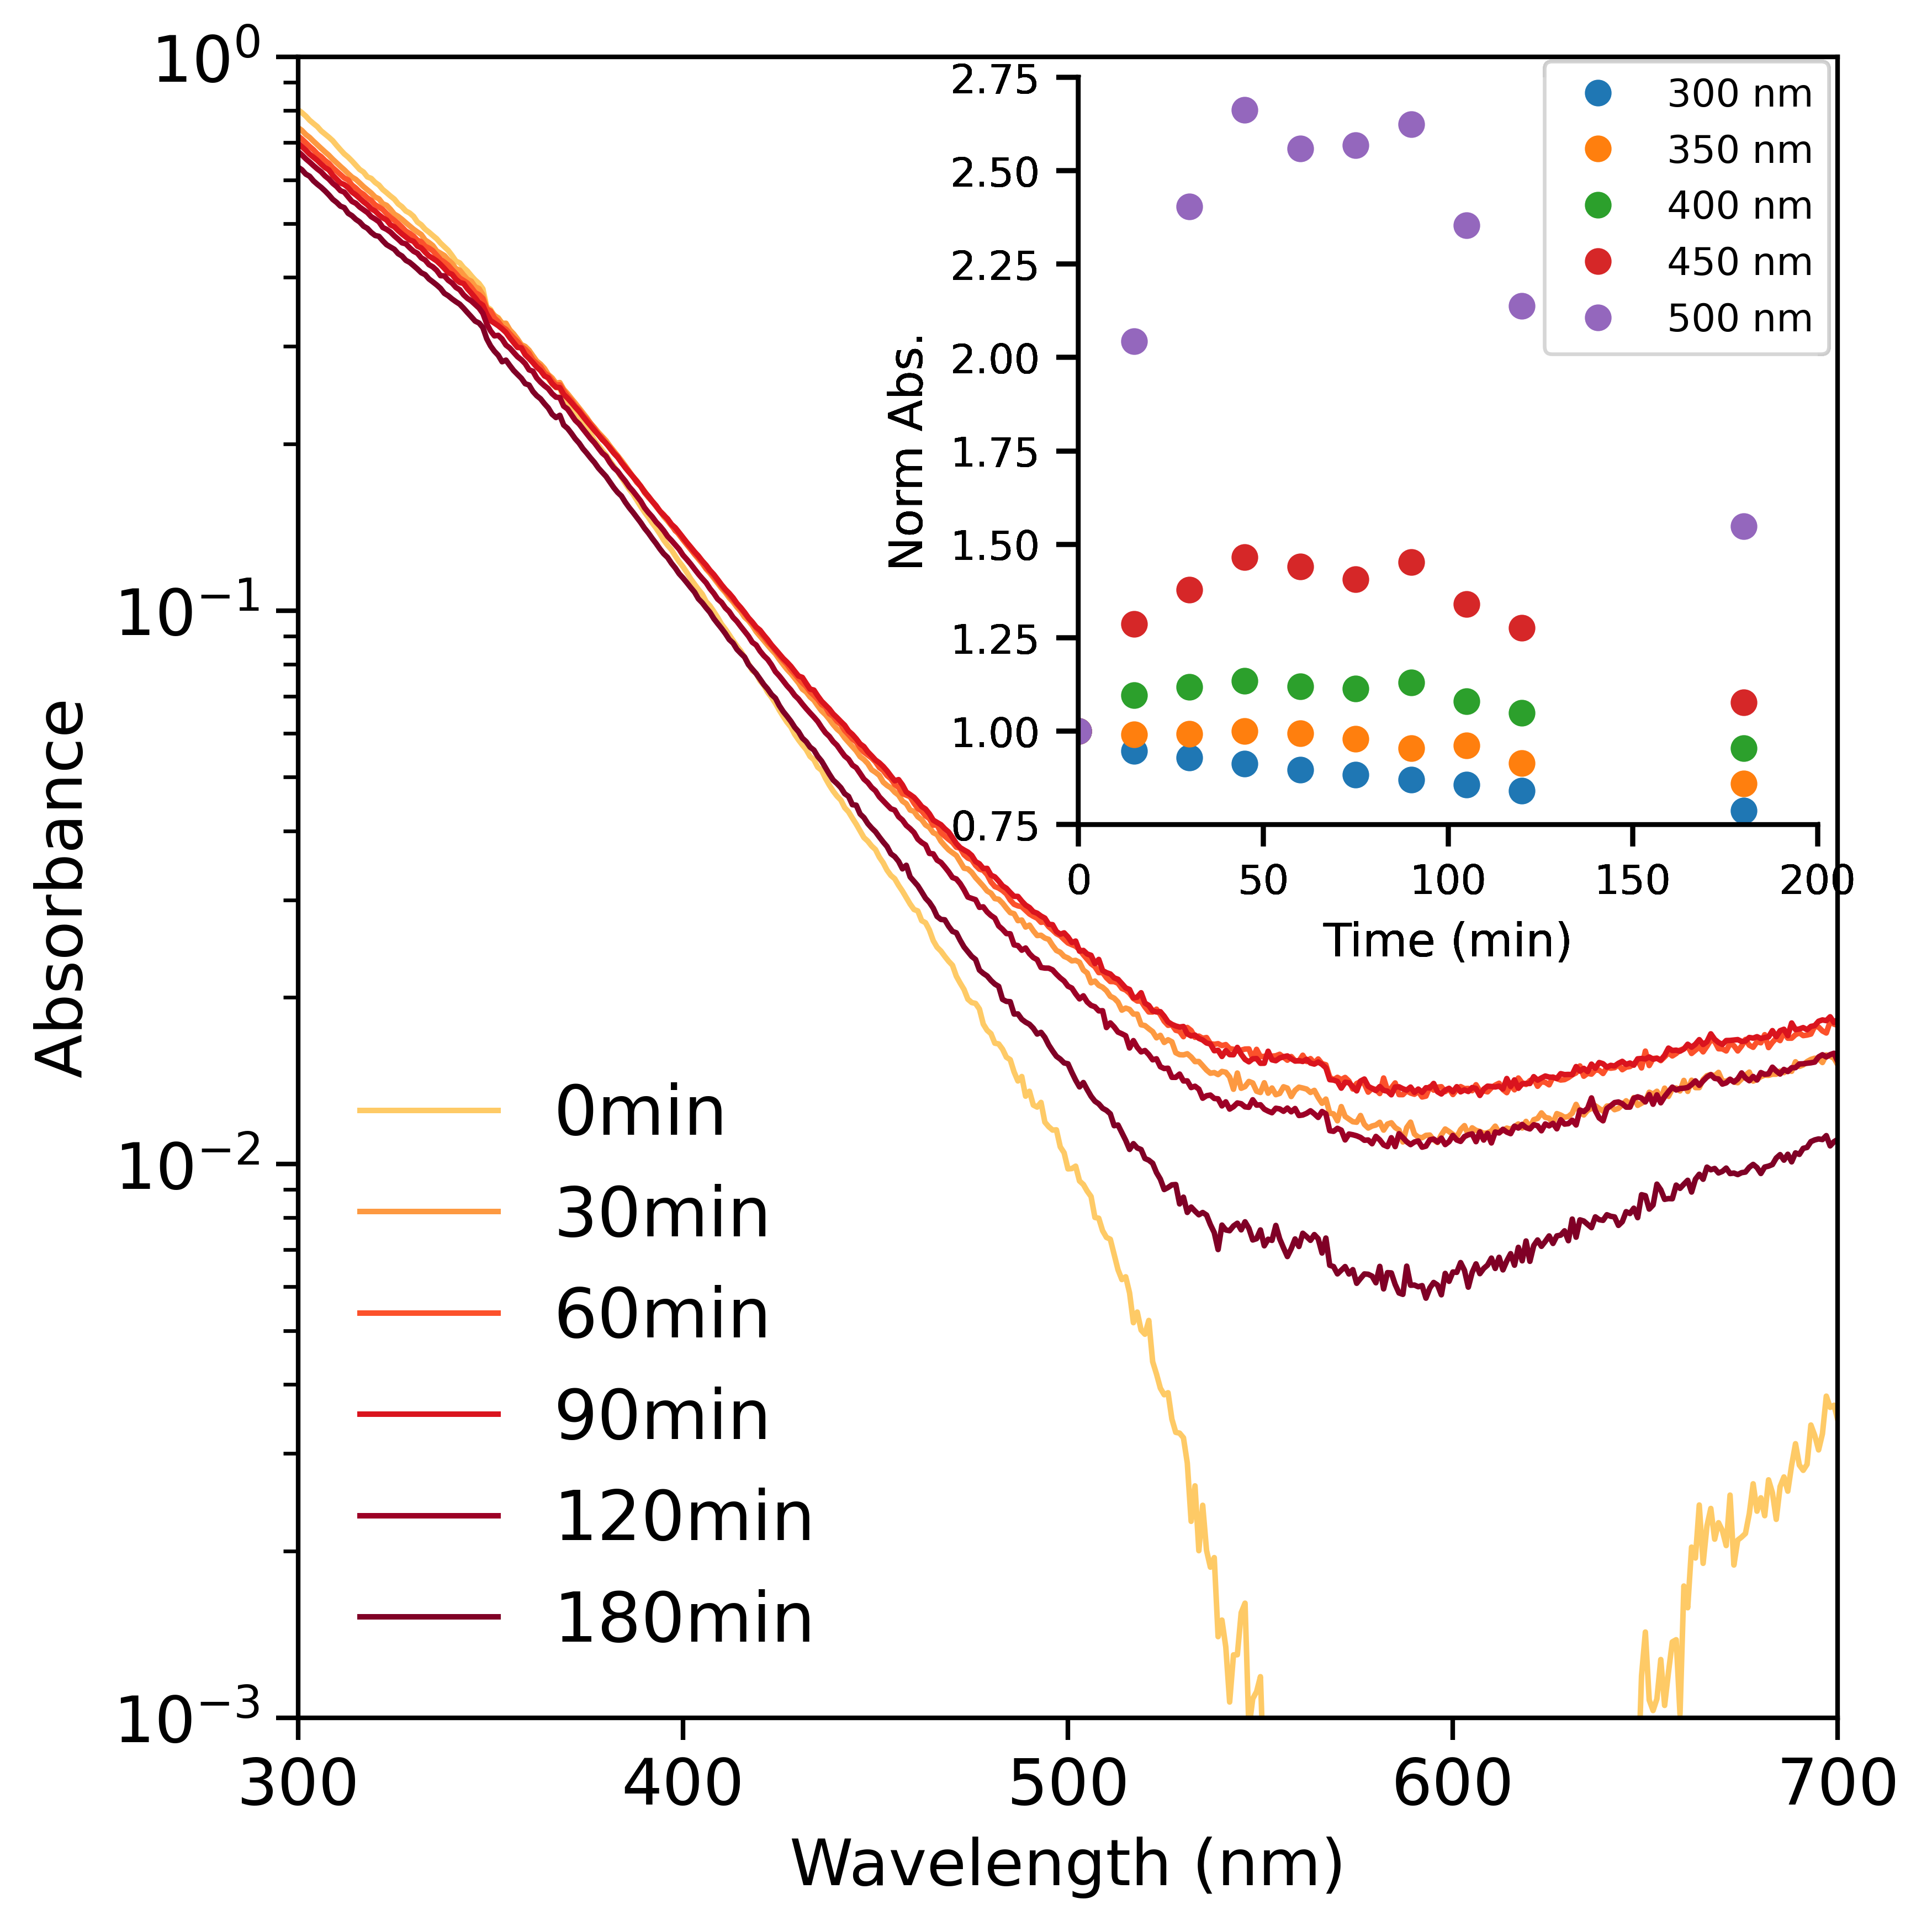

In [179]:
#import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
def mac_progression(df, main_ax,txt,legend=False):
    # Create inset_axes in the upper right corner, with separate x,y axis
    axins = inset_axes(main_ax, width="48%", height="45%", loc=1)  # 1: upper right corner
    #axins = inset_axes(main_ax, width="40%", height="40%", loc=1)  # for the BR vs BR chart
    
    wavelength = [300,350,400,450,500]

    #vis = df[(df.index > 400) & (df.index <= 500)]

    #uv = df[(df.index >= 280) & (df.index <= 400)]

    # For visible
    
    #vis_data = vis.sum(axis=0) / vis.sum(axis=0)[0]
    #uv_data = uv.sum(axis=0) / uv.sum(axis=0)[0]
    #print(df)
    for lamda in wavelength:
        axins.plot(df.loc[lamda]/df.loc[lamda].iloc[0],label=str(lamda)+' nm',marker='o',linestyle='None')
    #axis
    axins.annotate(txt,xy=(0, 1.2), xycoords="axes fraction", 
               xytext=(10, -10), textcoords="offset points", 
               ha="left", va="top",)
    #axins.plot(vis_data,  color='red',marker='x',label='Vis')
    #axins.scatter(vis_data.index, vis_data.values, color='red', s=15,marker='x',label='Vis')  # scatter plot for visible

    #axins.plot(uv_data,  color='blue',marker='x',label='UV')
    #axins.scatter(uv_data.index, uv_data.values, color='blue', s=15,marker='x',label='UV')  # scatter plot for UV
    if legend:
        axins.legend(loc=(0.63,0.63), fontsize='x-small',frameon=True)
        #axins.legend(loc='center right', fontsize='x-small',frameon=False) ##for Br vs BR

    axins.set_xlabel('Time (min)', fontsize=10)
    axins.set_ylabel('Norm Abs.', fontsize=10)
    axins.tick_params(axis='both', which='both')
    axins.set_ylim((0.75,2.75))
    axins.set_xlim((0,200))
    #axins.set_ylim((,1))

    axins.spines['top'].set_visible(False)
    axins.spines['right'].set_visible(False)
#import matplotlib
%config InlineBackend.figure_format='retina'
col_list = [0, 30, 60, 90, 120,180]
cmap = plt.get_cmap('YlOrRd')
colors = cmap(np.linspace(0.3, 1.1, len(col_list)))
fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=300)
for idx, col in enumerate(col_list):
    ax.plot(srfa.index, srfa[col], label=str(col)+'min', color=colors[idx])
    #ax[1].plot(df_BR_dry_beaker.index, 1e-2*df_BR_dry_beaker[col]/MAC_conv[6], label=str(col)+'min', color=colors[idx])
    mac_progression(srfa,ax,'',True)

ax.set_xlim(300,700)
ax.set_ylim(1e-3,1e0)
ax.set_yscale('log')
ax.set_xlabel('Wavelength (nm)',fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)

ax.set_ylabel('Absorbance',fontsize=14)
ax.legend(loc='lower left',frameon=False,fontsize=15)
plt.tight_layout()